# Matrix-free iterations

One of the most important aspects of Krylov methods is that the only way they need to interact with the matrix of the problem is through applications of it to specific vectors computed throughout the iteration. Since matrix$\times$vector is equivalent to a linear transformation, we can substitute code that applies the linear transformation. This is often easier than using the matrix itself. 

## Eigenvalues of a not-matrix

Remember the NFL team ranking algorithm? Here is the code that was developed for it.

In [1]:
using CSV,LinearAlgebra,SparseArrays
data = CSV.read("nfl2017.csv")
team = sort(unique(data[7]))

# remove ties
data = filter(r->r[9]>r[10],data)

# tally the games
V = zeros(32,32)
for g = 1:size(data,1)
    winner = findfirst(data[g,5].==team)
    loser = findfirst(data[g,7].==team)
    V[winner,loser] += 1
end
V = sparse(V)

losses = sum(V,dims=1)

rows,vals = rowvals(V),nonzeros(V)
function redist(c)
    cnew = zero(c)
    for t = 1:32
        # redistribute team t's share
        for i in nzrange(V,t)
            cnew[rows[i]] += c[t]*vals[i]/losses[t]
        end
    end
    return cnew
end

redist (generic function with 1 method)

Now, we went on to remark that the action of `redist(c)` is really just `V*c`. However, we can regard `redist` as a perfectly good substitute for the matrix itself, for the purposes of power/Krylov iterations. Here we use a package that explicitly wraps it for us in something Julia will see as "matrix-like." 

In [2]:
using LinearMaps
L = LinearMap(redist,32)
@show size(L)

size(L) = (32, 32)


(32, 32)

Again, the map `L` doesn't really "know about" the underlying matrix, just that it acts linearly in 32 dimensions. Now we can use a package that implements Arnoldi for such a representation. It will tend to find the largest eigenvalues first, though you can also request different targets and apply shifts.

In [3]:
using ArnoldiMethod
S,his = partialschur(L,nev=4)

┌ Info: Precompiling ArnoldiMethod [ec485272-7323-5ecc-a04f-4719b315124d]
└ @ Base loading.jl:1186


(ArnoldiMethod.PartialSchur{SubArray{Float64,2,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true},SubArray{Float64,2,Array{Float64,2},Tuple{UnitRange{Int64},UnitRange{Int64}},false},Complex{Float64}}([0.111522 -0.0814234 -0.0439995 0.125889; 0.256177 0.202069 0.242657 0.0805657; … ; 0.147843 -0.126138 0.278451 0.0388438; 0.111556 -0.174893 -0.110248 0.0916703], [1.0 -0.08285 0.108156 0.161387; 0.0 0.514973 0.0953567 -0.0160268; 0.0 0.0 -0.112056 -0.440544; 0.0 0.0 0.454239 -0.163686], Complex{Float64}[1.0+0.0im, 0.514973+0.0im, -0.137871+0.446594im, -0.137871-0.446594im]), Converged: 4 of 4 eigenvalues in 38 matrix-vector products)

In [4]:
λ,X = partialeigen(S);
@show λ;

λ = Complex{Float64}[1.0+0.0im, 0.514973+0.0im, -0.137871+0.446594im, -0.137871-0.446594im]


As before, we find the dominant eigenvalue at 1, and its eigenvector provides the ranking. 

In [5]:
team[sortperm(abs.(X[:,1]),rev=true)[1:8]]

8-element Array{Union{Missing, String},1}:
 "Philadelphia Eagles" 
 "New England Patriots"
 "Kansas City Chiefs"  
 "New Orleans Saints"  
 "Carolina Panthers"   
 "Minnesota Vikings"   
 "Atlanta Falcons"     
 "Seattle Seahawks"    

Perhaps you're unimpressed, since we could just as well have used the sparse matrix. But suppose you're doing PageRank for the web. All you have to do is seed a set of webpages with probability, then randomly follow links from those pages to redistribute it. For a truly large set of pages, you might be grateful not to need that matrix.

## What's the (finite) difference?

Consider solving the PDE $u_{xx} + u_{yy}=-1$ on a unit square (with zero boundary conditions). It's easy to set up an $n\times n$ grid and replace the partial second derivatives with "1,-2,1" finite differences. The whole process of mapping a grid of $u$ values to the values of the discrete Laplacian is linear, so it can be represented by an underlying matrix. But we don't need the matrix in order to apply a Krylov solver!

Here is a function that does the differencing procedure. It pads out the given values, which lie in the interior, with a border of zero values around the boundary of the square. 

In [6]:
function lap(u,n)
    u = reshape(u,n-1,n-1)
    z = zeros(n-1)
    v = diff(diff([z';u;z'],dims=1),dims=1) + diff(diff([z u z],dims=2),dims=2)
    return (n-1)^2*v
end

lap (generic function with 1 method)

In [7]:
n = 4
laplacian(n) = LinearMap(u->lap(u,n),(n-1)^2)

laplacian (generic function with 1 method)

Now, it is possible to extract the matrix out of the operator `L`, just by applying it to the columns of an identity.

In [8]:
Matrix(laplacian(4))

9×9 Array{Float64,2}:
 -36.0    9.0    0.0    9.0    0.0    0.0    0.0    0.0    0.0
   9.0  -36.0    9.0    0.0    9.0    0.0    0.0    0.0    0.0
   0.0    9.0  -36.0    0.0    0.0    9.0    0.0    0.0    0.0
   9.0    0.0    0.0  -36.0    9.0    0.0    9.0    0.0    0.0
   0.0    9.0    0.0    9.0  -36.0    9.0    0.0    9.0    0.0
   0.0    0.0    9.0    0.0    9.0  -36.0    0.0    0.0    9.0
   0.0    0.0    0.0    9.0    0.0    0.0  -36.0    9.0    0.0
   0.0    0.0    0.0    0.0    9.0    0.0    9.0  -36.0    9.0
   0.0    0.0    0.0    0.0    0.0    9.0    0.0    9.0  -36.0

But that misses the point! We can solve a linear system without it.

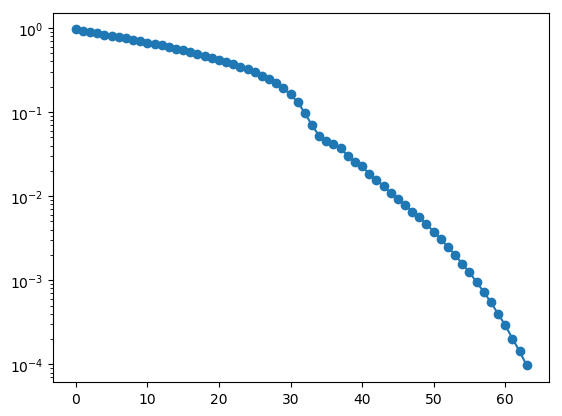

In [12]:
using IterativeSolvers, PyPlot
n = 50; b = -ones((n-1)^2)
u,his = minres(laplacian(n),b,log=true,tol=1e-4)
semilogy(his[:resnorm]/norm(b),"-o");

Here's a peek at the solution over the square.

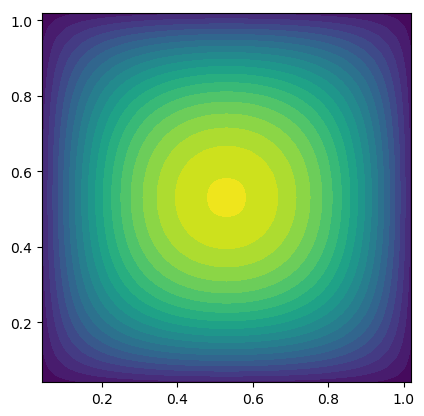

In [13]:
X = [ i/(n-1) for i=2:n, j=2:n ]
Y = [ j/(n-1) for i=2:n, j=2:n ]
contourf(X,Y,reshape(u,n-1,n-1),20)
axis("square");

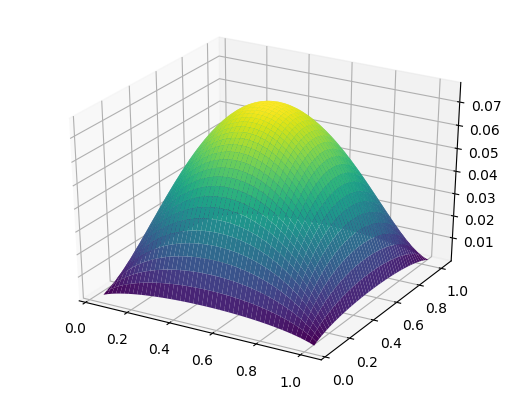

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x13fe84278>

In [14]:
surf(X,Y,reshape(u,n-1,n-1),cmap=:viridis)